https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [2]:
from glob import glob
import os
import numpy as np
import torch
from PIL import Image
os.chdir('./DefectData')
#os.chdir('D://Justin/DefectData')
import matplotlib.pyplot as plt


In [2]:
!nvidia-smi

Tue Apr 18 15:57:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:41:00.0 Off |                  Off |
|  0%   32C    P8    41W / 480W |     71MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:61:00.0 Off |                  Off |
|  0%   

In [3]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         48 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  32
  On-line CPU(s) list:   0-31
Vendor ID:               AuthenticAMD
  Model name:            AMD Ryzen Threadripper PRO 5955WX 16-Cores
    CPU family:          25
    Model:               8
    Thread(s) per core:  2
    Core(s) per socket:  16
    Socket(s):           1
    Stepping:            2
    Frequency boost:     enabled
    CPU max MHz:         7031.2500
    CPU min MHz:         1800.0000
    BogoMIPS:            7984.46
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall n
                         x mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_go
                         od nopl nonstop_tsc cpuid extd_apicid aperfmperf rapl p
                         ni pclmulqdq moni

In [4]:
!cat /proc/meminfo

MemTotal:       263736640 kB
MemFree:        98158224 kB
MemAvailable:   239941280 kB
Buffers:         1520964 kB
Cached:         132895484 kB
SwapCached:           36 kB
Active:         38231000 kB
Inactive:       113278496 kB
Active(anon):       8836 kB
Inactive(anon): 17574996 kB
Active(file):   38222164 kB
Inactive(file): 95703500 kB
Unevictable:          48 kB
Mlocked:              48 kB
SwapTotal:       2097148 kB
SwapFree:        2095356 kB
Zswap:                 0 kB
Zswapped:              0 kB
Dirty:             17560 kB
Writeback:             0 kB
AnonPages:      17057712 kB
Mapped:          2068820 kB
Shmem:            505408 kB
KReclaimable:   10148792 kB
Slab:           12234464 kB
SReclaimable:   10148792 kB
SUnreclaim:      2085672 kB
KernelStack:       52320 kB
PageTables:       104200 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    133965468 kB
Committed_AS:   41077216 kB
VmallocTotal:   34359738367 kB
VmallocUsed:

In [5]:
!pip list

Package            Version
------------------ ------------
asttokens          2.2.1
backcall           0.2.0
certifi            2022.12.7
charset-normalizer 2.1.1
cmake              3.25.0
comm               0.1.3
contourpy          1.0.7
cycler             0.11.0
Cython             0.29.34
debugpy            1.6.7
decorator          5.1.1
executing          1.2.0
filelock           3.9.0
fonttools          4.39.3
idna               3.4
ipykernel          6.22.0
ipython            8.12.0
jedi               0.18.2
Jinja2             3.1.2
jupyter_client     8.1.0
jupyter_core       5.3.0
kiwisolver         1.4.4
lit                15.0.7
MarkupSafe         2.1.2
matplotlib         3.7.1
matplotlib-inline  0.1.6
mpmath             1.2.1
nest-asyncio       1.5.6
networkx           3.0
numpy              1.24.2
packaging          23.1
parso              0.8.3
pexpect            4.8.0
pickleshare        0.7.5
Pillow             9.5.0
pip                22.0.2
platformdirs       3.2.0
prompt

In [14]:
class DefectDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = []
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(glob('./train/[0-9][0-9][0-9][0-9][0-9].png')))
        self.masks = list(sorted(glob('./train/[0-9][0-9][0-9][0-9][0-9]_GT.png')))

        if transforms!=None:
          self.transforms.append(transforms)

    def __getitem__(self, idx):
        # load images ad masks
        #print('idx:', idx)
        img_path = os.path.join(self.root, self.imgs[idx])
        #print('img_path', self.imgs[idx])
        mask_path = os.path.join(self.root, self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        #print(num_objs)
        boxes = []
        for i in range(num_objs):
          pos = np.where(masks[i])
          xmin = np.min(pos[1])
          xmax = np.max(pos[1])
          ymin = np.min(pos[0])
          ymax = np.max(pos[0])
          boxes.append([xmin, ymin, xmax, ymax])

        #print('nr boxes is equal to nr ids:', len(boxes)==len(obj_ids))
        num_objs = len(obj_ids)
        # convert everything into a torch.Tensor
        if len(boxes) > 0:
          boxes = torch.as_tensor(boxes, dtype=torch.float32)
        else:
          boxes = torch.empty((0,4))
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        if len(boxes) > 0:
          area = (boxes[:,3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
          area = [[]]
        
        area = torch.as_tensor(area)
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        for i in self.transforms:
          img = i(img)

        target = {}
        target["boxes"] = boxes
        target["masks"] = masks
        target["labels"] = labels # Not sure if this is needed
        target["area"] = area
        target["iscrowd"] = iscrowd

        return img.double(), target
    def __len__(self):
        return len(self.imgs)

In [15]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [16]:
import torch
from torchvision import transforms
import utils

transform_train = transforms.transforms.Compose([
    transforms.ToTensor()]
)

In [17]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = DefectDataset('', transform_train)
data_loader_train = torch.utils.data.DataLoader(
    dataset, batch_size=12, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader_train))
images = list(image.float() for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

num_classes = 2
# load an instance segmentation model pre-trained pre-trained on COCO
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# now get the number of input features for the mask classifier
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                    hidden_layer,
                                                    num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model=model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-5, momentum=1, weight_decay=0.0005)

/home/jpminer/Documents/RCNN/RCNN/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jpminer/Documents/RCNN/RCNN/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


100%|██████████| 195/195 [24:10<00:00,  7.44s/it]


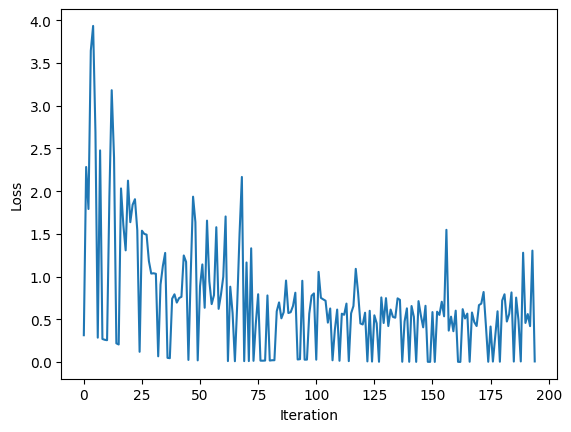

Average loss for epoch = 0.7230 


100%|██████████| 195/195 [24:46<00:00,  7.62s/it]


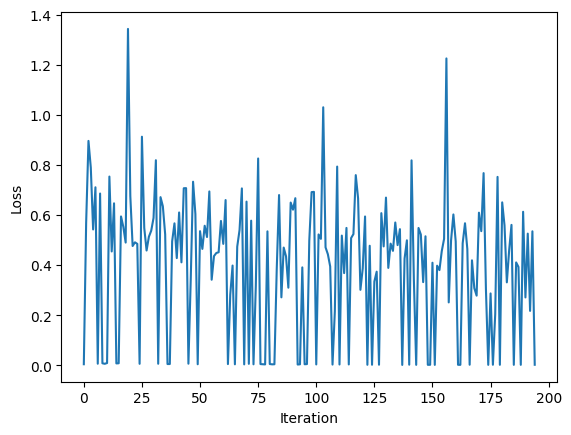

Average loss for epoch = 0.3969 


100%|██████████| 195/195 [30:56<00:00,  9.52s/it]


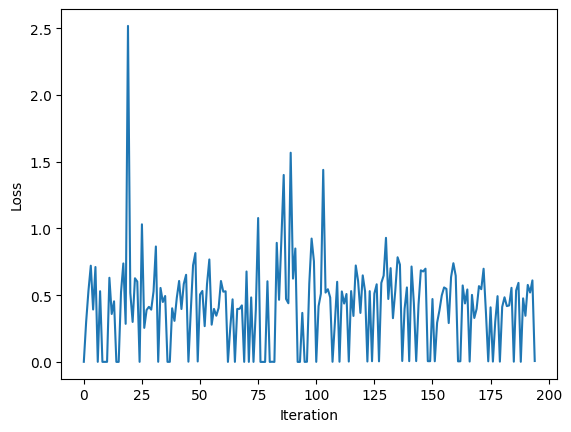

Average loss for epoch = 0.4202 


100%|██████████| 195/195 [25:03<00:00,  7.71s/it]


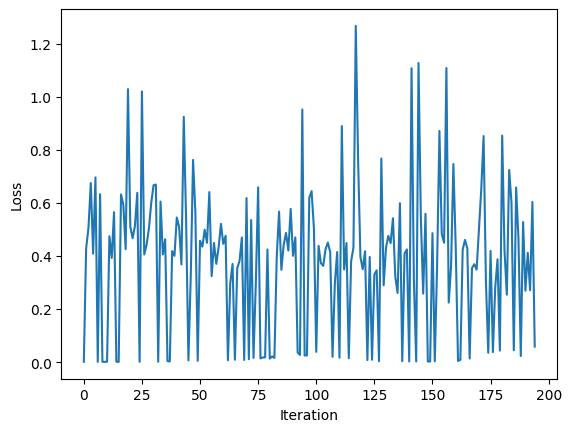

Average loss for epoch = 0.3811 


100%|██████████| 195/195 [24:07<00:00,  7.42s/it]


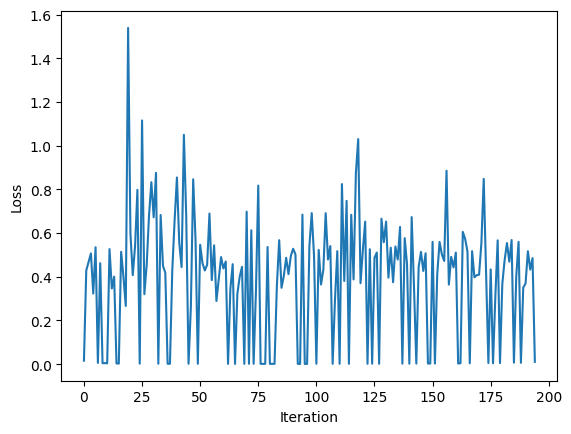

Average loss for epoch = 0.3947 


In [11]:
from tqdm import tqdm
# Perform training loop for n epochs
loss_list = []
loss_overall = []
n_epochs = 5
model.train()
iteration=1
for epoch in range(n_epochs):
    loss_epoch = []
    for images,targets in tqdm(data_loader_train):
        images = list(image.double().to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        model=model.double()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()       
        optimizer.step()
        # print('loss:', losses.item())
        # loss_epoch.append(losses.item())
        loss_epoch.append(losses.item())
        loss_overall.append(losses.item())
        iteration+=1
        # Plot loss every 10th iteration
    loss_epoch_mean = np.mean(loss_epoch) 
    plt.plot(range(len(loss_epoch)), loss_epoch)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()
    loss_list.append(loss_epoch_mean) 
    # loss_list.append(loss_epoch_mean)    
    print("Average loss for epoch = {:.4f} ".format(loss_epoch_mean))

# Save model
save_path = 'model.pth'
torch.save(model, save_path)
np.save('maskloss.npy', loss_overall)

NameError: name 'device' is not defined

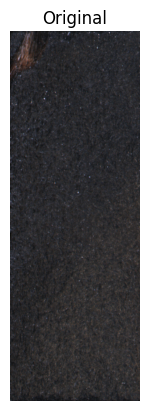

In [4]:
import torch
from torchvision import transforms
model.eval()

plt.figure()
plt.subplot(131)
img = Image.open('train/10021.png')
plt.imshow(img)
plt.axis('off')
plt.title('Original')

transform = transforms.transforms.Compose([transforms.ToTensor()])
img_tensor = transform(img).double().to(device)
pred = model([img_tensor])

masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
scores = (pred[0]['scores']).squeeze().detach().cpu().numpy()

plt.subplot(132)
plt.imshow(np.sum(masks[scores > 0.10], axis = 0)>.5)
plt.axis('off')
plt.title('MaskRCNN')

plt.subplot(133)
mask = Image.open('train/10021_GT.png')
plt.imshow(mask)

plt.axis('off')
plt.title('Ground Truth')

plt.tight_layout()



In [8]:
from tqdm import tqdm
testimages = list(sorted(glob('./test/[0-9][0-9][0-9][0-9][0-9].png')))
testimages.sort()
testmasks = list(sorted(glob('./test/[0-9][0-9][0-9][0-9][0-9]_GT.png')))
testmasks.sort()

num_classes = 2

model = torch.load('model.pth')

model.eval()

transform = transforms.transforms.Compose([transforms.ToTensor()])

ious = []

for i, fpath in enumerate(tqdm(testimages)):
    image = Image.open(fpath)
    img_tensor = transform(image).double().to(device)
    pred = model([img_tensor])
    masks = (pred[0]['masks']>0.9).squeeze().detach().cpu().numpy()
    scores = pred[0]['scores'].detach().cpu().numpy()
    if len(scores) == 1:
        masks = masks[np.newaxis, :, :]
    masks = masks[scores > 0.11]
    predmask = np.sum(masks, axis = 0) > 1.5
    predmask = np.clip(predmask, 0, 1)
    mask = np.array(Image.open(testmasks[i]))
    mask = np.clip(mask, 0,1)

    intersection = np.sum(mask&predmask)
    union = np.sum(mask|predmask)
    if union>0:
        ious.append(float(intersection)/union)
    else:
        ious.append(1)

  1%|          | 11/1004 [00:06<09:53,  1.67it/s]


KeyboardInterrupt: 

In [19]:
ious = np.asarray(ious)
print(np.average(ious))

0.8915756753486128


In [20]:
np.save('maskloss.npy', loss_list)